<a href="https://colab.research.google.com/github/pylabview/sales-predicctions/blob/main/Project_1_Revisited.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib


#Setting plots styles
plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

## Importing Custom Functions
import sys,os
sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
from CODE import data_enrichment as de

/var/folders/6z/wccfr6994pg1zc7gyrxzjvdw0000gn/T/ipykernel_1642/2516318757.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])
/var/folders/6z/wccfr6994pg1zc7gyrxzjvdw0000gn/T/ipykernel_1642/2516318757.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['dark_background','seaborn-muted', 'seaborn-poster'])


## Loading Data

In [2]:
df = pd.read_csv("./Data/sales_predictions.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Cleaning Data

In [3]:
# Are there duplicates? If so, drop any duplicates.
dups = df.duplicated().sum()
print(f"Number of duplicates: {dups}")

Number of duplicates: 0


In [4]:
# 4) Identify missing values.
total_missing_series = df.isna().sum()
total_missing_series_idx = df.isna().sum().index
total_cols = len(total_missing_series_idx )

for i in range(total_cols):
    if total_missing_series[i] > 0:
        print(f"Row index {total_missing_series_idx[i]}, number of missing {total_missing_series[i]}")

Row index Item_Weight, number of missing 1463
Row index Outlet_Size, number of missing 2410


In [5]:
# Inputing missing data for Item_Weight with the column average, as the data type is a float
df['Item_Weight'].fillna(value = df['Item_Weight'].mean(), inplace = True)

#Dropping Outlet_Size, the misssing values are >5% and this column should not affect the food sales prediction

df.drop(columns=['Outlet_Size'],inplace=True)



In [6]:
# 6) Confirm that there are no missing values after addressing them.
print(f"Are All missing values removed? {df.isna().sum().sum()==0}")

Are All missing values removed? True


In [7]:
# 7) Find and fix any inconsistent categories of data 
## Item_Fat_Content

df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [8]:
#Repalcing inconsisten values: 'low fat', 'LF', 'reg'
df.replace({'low fat': 'Low Fat',
            'LF': 'Low Fat',
            'reg':'Regular'}, inplace = True)

In [9]:
#Cheking everything is OK!

df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [10]:
#8) For any numerical columns, obtain the summary statistics of each (min, max, mean).
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


## EDA

In [12]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Preprocessing (with Sklearn v1.1+)

In [13]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


In [14]:
# ### Train Test Split
## Make x and y variables
target = "Item_Outlet_Sales"
drop_feats = ['Item_Identifier']

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head(3)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Tier 2,Supermarket Type1



### Column Selector

Identifying features (Numerical, Categorical)
- Numerical: `'Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year'`

- Categoricals:
  - Nominals: `'Outlet_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Type', 'Outlet_Location_Type'`


In [15]:
## Make a column selector for categories & test it /sanity check
cat_features = ['Outlet_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Type', 'Outlet_Location_Type']
num_selector = make_column_selector(dtype_include='number')
cat_selector = cat_features


### **Transformers**

In [16]:
# Instantiate the transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

mean_imputer = SimpleImputer(strategy='mean')

### Pipeline Numeric Data and a Pipeline for Categorical Data

In [17]:
num_pipeline = make_pipeline(mean_imputer, scaler)


### **Tuples**

In [18]:
# Create tuples
number_tuple = (num_pipeline, num_selector)
category_tuple = (ohe,cat_selector)

### **ColumnTransformer**

In [19]:
# Create the preprocessor using make_column_transformer
preprocessor = make_column_transformer(number_tuple, 
                                       category_tuple, 
                                       remainder='drop')
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28e9c12e0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Outlet_Identifier', 'Item_Fat_Content',
                                  'Item_Type', 'Outlet_Type',
                                  'Outlet_Location_Type'])])

In [20]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x28e9c12e0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['Outlet_Identifier', 'Item_Fat_Content',
                                  'Item_Type', 'Outlet_Type',
                                  'Outlet_Location_Type'])])

### Make X_train_df and X_test_df, dataframe verisons of processed X_train/X_test.

In [21]:
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

,pipeline__Item_Weight,pipeline__Item_Visibility,pipeline__Item_MRP,pipeline__Outlet_Establishment_Year,onehotencoder__Outlet_Identifier_OUT010,onehotencoder__Outlet_Identifier_OUT013,onehotencoder__Outlet_Identifier_OUT017,onehotencoder__Outlet_Identifier_OUT018,onehotencoder__Outlet_Identifier_OUT019,onehotencoder__Outlet_Identifier_OUT027,...,onehotencoder__Item_Type_Snack Foods,onehotencoder__Item_Type_Soft Drinks,onehotencoder__Item_Type_Starchy Foods,onehotencoder__Outlet_Type_Grocery Store,onehotencoder__Outlet_Type_Supermarket Type1,onehotencoder__Outlet_Type_Supermarket Type2,onehotencoder__Outlet_Type_Supermarket Type3,onehotencoder__Outlet_Location_Type_Tier 1,onehotencoder__Outlet_Location_Type_Tier 2,onehotencoder__Outlet_Location_Type_Tier 3
8269,-1.320469,-0.043295,-1.268171,0.026015,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7604,-1.575911,0.248066,-0.459996,1.338206,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2762,-0.159793,-0.726880,0.182616,0.741756,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6464,-1.620643,0.511794,-0.192206,0.741756,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4707,1.264565,-0.002094,1.735461,0.741756,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,0.006809,-1.041803,0.371897,-1.524756,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8360,-0.312823,-0.990499,0.561178,0.145305,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5929,-1.817228,-0.604724,0.344948,0.503176,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4220,-1.478207,-0.607519,0.286927,1.099626,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Get Features Names + Verbose Feature Names Out

In [22]:
## make the preprocessing column transformer WITH CORRECT ARGS!
preprocessor = make_column_transformer((num_pipeline, num_selector),
                                      verbose_feature_names_out=False)
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
8269,-1.320469,-0.043295,-1.268171,0.026015
7604,-1.575911,0.248066,-0.459996,1.338206
2762,-0.159793,-0.726880,0.182616,0.741756
6464,-1.620643,0.511794,-0.192206,0.741756
4707,1.264565,-0.002094,1.735461,0.741756
...,...,...,...,...
3482,0.006809,-1.041803,0.371897,-1.524756
8360,-0.312823,-0.990499,0.561178,0.145305
5929,-1.817228,-0.604724,0.344948,0.503176
4220,-1.478207,-0.607519,0.286927,1.099626


## Modeling - Linear Regression

In [23]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")


In [24]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.34,"1,012.90","1,370.71"
Test,0.34,"1,048.37","1,422.88"


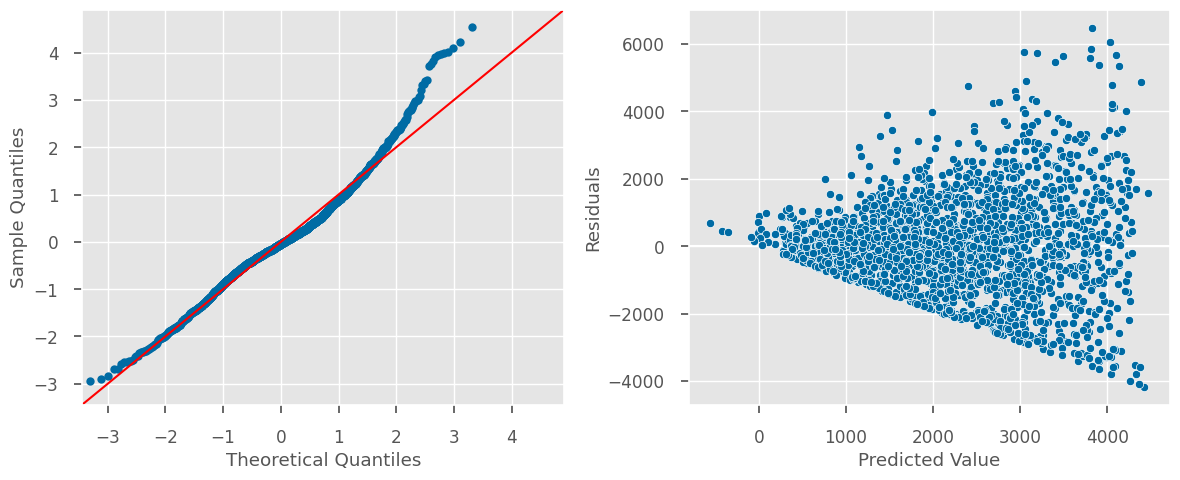

In [25]:
de.plot_residuals(lin_reg, X_test_df,y_test)

### Extracting and Visualizing Coefficients

In [26]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [27]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                    -1.559855
Item_Visibility              -225.833983
Item_MRP                      959.946664
Outlet_Establishment_Year     -93.652227
intercept                    2153.643011
dtype: float64

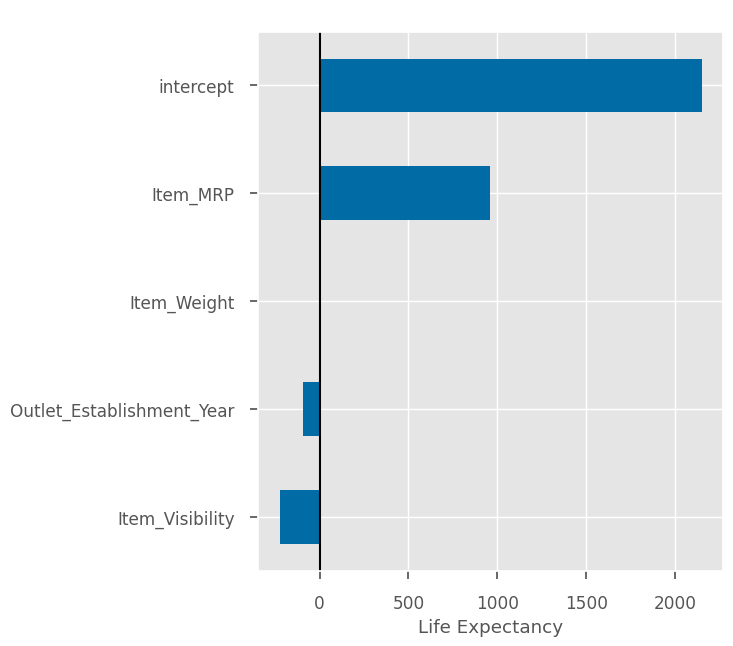

In [28]:
## Plot country ceoffs
ax = coeffs.sort_values().plot(kind='barh', figsize=(6,7))
ax.axvline(0, color='k')
ax.set(xlabel='Life Expectancy', title="Coefficients - Countries");

### Summary
- What features made the model predict a higher price?
  >- Item_MRP

- Which feature made the model predict a lower price?
  >- Item_Weight, Item_Visibility
- What effect does having more visibility have on predicted price?
  >- Decreases home value by ~$220

## Feature Importance

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.91,347.61,498.31
Test,0.36,982.02,"1,403.88"


In [31]:
## Saving the coefficients
importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
importances

Item_Weight                  0.085062
Item_Visibility              0.239251
Item_MRP                     0.539710
Outlet_Establishment_Year    0.135978
dtype: float64

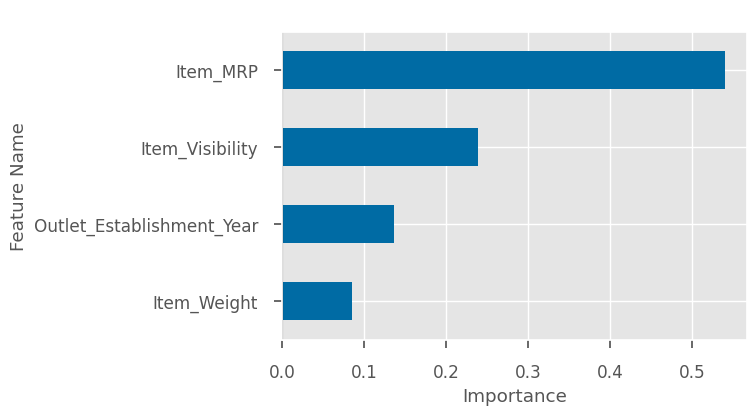

In [32]:
ax = importances.sort_values().tail(20).plot(kind='barh',figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');

### Summary
- What features made the model predict a higher price?
>  - Item_MRP, Item_Visivility, Item_Weight

- Which feature made the model predict a lower price?
>  - None


## Using joblib to Save our Model, Data, and Objects

In [33]:
X_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Location_Type,Outlet_Type
8269,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,Tier 3,Grocery Store
7604,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Tier 3,Supermarket Type2
2762,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Tier 2,Supermarket Type1
6464,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Tier 2,Supermarket Type1
4707,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Tier 2,Supermarket Type1


In [34]:
evaluate_regression(lin_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.34,"1,012.90","1,370.71"
Test,0.34,"1,048.37","1,422.88"


In [35]:
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

Split,R^2,MAE,RMSE
Train,0.91,347.61,498.31
Test,0.36,982.02,"1,403.88"


In [36]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'RandomForestRegressor':rf_reg
         }

In [37]:
folder = "Models/"
os.makedirs(folder, exist_ok=True)

In [38]:
fname = folder+'wk1-lect01-codealong.joblib'
joblib.dump(export, fname)

['Models/wk1-lect01-codealong.joblib']

In [39]:
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])